# Baseline Results for Multiclass Classification (pain area in body)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.utils import compute_class_weight
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import KFold
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras import Model

import sys
module_path = os.path.abspath(os.getcwd() + '\\..')
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data.load_dataset import load_dataset, get_class_names, load_fusioned_dataset
from src.lib.DeepStack.deepstack.base import KerasMember
from src.lib.DeepStack.deepstack.ensemble import DirichletEnsemble

In [2]:
epochs, batch_size = 50, 32
kf = KFold(n_splits=3, shuffle=True, random_state=42)

results = []

early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True,
    )

In [3]:
class Baseline():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(n_length, n_features))
        lstm = LSTM(50)(input)
        dense = Dense(50)(lstm)
        output = Dense(units=n_outputs, activation='softmax')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, class_weight=class_weight, verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

    def summary(self):
        self.model.summary()

## 1. Unimodal Body Modality (Skeleton)

### Dataset

In [4]:
X_train, X_test, y_train, y_test = load_dataset('skeleton', nopain=False)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[2], X_train.shape[3])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2], X_test.shape[3])
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[1], X_train.shape[-1], y_train.shape[1]

(380, 350, 35) (380, 4)
(235, 350, 35) (235, 4)


In [5]:
classes = get_class_names('skeleton', nopain=False)
tmp = pd.DataFrame(classes)
classes = tmp.value_counts()
classes

Lower Body       245
Back Region       73
Upper Body        57
Head and Neck      5
dtype: int64

In [6]:
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 1.3013698630136987, 1: 19.0, 2: 0.3877551020408163, 3: 1.6666666666666667}

In [7]:
model = Baseline(n_features, n_length, n_outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 350, 35)]         0         
                                                                 
 lstm (LSTM)                 (None, 50)                17200     
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
 dense_1 (Dense)             (None, 4)                 204       
                                                                 
Total params: 19,954
Trainable params: 19,954
Non-trainable params: 0
_________________________________________________________________


### Baseline Model

Epoch 1/50
8/8 - 4s - loss: 1.5934 - accuracy: 0.4545 - auc_1: 0.7070 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - f1_score: 0.2028 - val_loss: 1.2177 - val_accuracy: 0.5039 - val_auc_1: 0.7301 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.2467 - 4s/epoch - 454ms/step
Epoch 2/50
8/8 - 1s - loss: 1.5678 - accuracy: 0.4348 - auc_1: 0.7006 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - f1_score: 0.2187 - val_loss: 1.2246 - val_accuracy: 0.4567 - val_auc_1: 0.7199 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.2342 - 679ms/epoch - 85ms/step
Epoch 3/50
8/8 - 1s - loss: 1.5524 - accuracy: 0.3755 - auc_1: 0.6879 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - f1_score: 0.1981 - val_loss: 1.2333 - val_accuracy: 0.4252 - val_auc_1: 0.7123 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.2221 - 686ms/epoch - 86ms/step
Epoch 4/50
8/8 - 1s - loss: 1.5368 - accuracy: 0.3715 - auc_1: 0.6839 - precision_1:

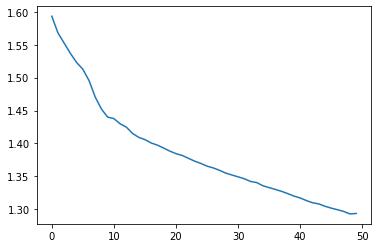

Epoch 1/50
8/8 - 3s - loss: 1.6388 - accuracy: 0.5178 - auc_2: 0.7000 - precision_2: 0.6000 - recall_2: 0.0356 - f1_score: 0.2376 - val_loss: 1.2220 - val_accuracy: 0.5433 - val_auc_2: 0.7247 - val_precision_2: 0.2500 - val_recall_2: 0.0079 - val_f1_score: 0.2830 - 3s/epoch - 332ms/step
Epoch 2/50
8/8 - 1s - loss: 1.6091 - accuracy: 0.5099 - auc_2: 0.7103 - precision_2: 0.5000 - recall_2: 0.0237 - f1_score: 0.2261 - val_loss: 1.2236 - val_accuracy: 0.5197 - val_auc_2: 0.7318 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_f1_score: 0.2691 - 654ms/epoch - 82ms/step
Epoch 3/50
8/8 - 1s - loss: 1.5734 - accuracy: 0.5257 - auc_2: 0.7301 - precision_2: 0.5000 - recall_2: 0.0158 - f1_score: 0.2340 - val_loss: 1.2320 - val_accuracy: 0.4882 - val_auc_2: 0.7312 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_f1_score: 0.2381 - 678ms/epoch - 85ms/step
Epoch 4/50
8/8 - 1s - loss: 1.5544 - accuracy: 0.5178 - auc_2: 0.7445 - precision_2: 0.3333 - recall_2: 0.0079 - f1_

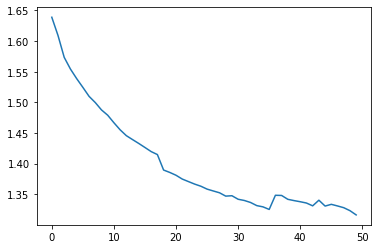

Epoch 1/50
8/8 - 3s - loss: 1.4193 - accuracy: 0.1457 - auc_3: 0.3946 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - f1_score: 0.1047 - val_loss: 1.4754 - val_accuracy: 0.2302 - val_auc_3: 0.4680 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_f1_score: 0.1553 - 3s/epoch - 366ms/step
Epoch 2/50
8/8 - 1s - loss: 1.3596 - accuracy: 0.2205 - auc_3: 0.4506 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - f1_score: 0.1484 - val_loss: 1.4152 - val_accuracy: 0.2857 - val_auc_3: 0.5331 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_f1_score: 0.1876 - 654ms/epoch - 82ms/step
Epoch 3/50
8/8 - 1s - loss: 1.3091 - accuracy: 0.3031 - auc_3: 0.5520 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - f1_score: 0.1975 - val_loss: 1.3762 - val_accuracy: 0.3095 - val_auc_3: 0.5888 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_f1_score: 0.1954 - 645ms/epoch - 81ms/step
Epoch 4/50
8/8 - 1s - loss: 1.2802 - accuracy: 0.3268 - auc_3: 0.6102 - precision_3:

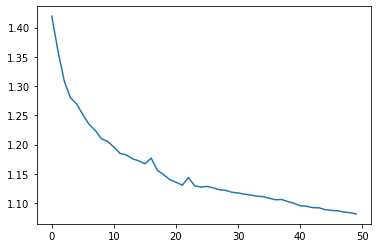

In [8]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    baseline_body_model = Baseline(n_features, n_length, n_outputs)
    history = baseline_body_model.train(X_train, y_train, X_val, y_val, epochs, batch_size, d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on holdout set

In [9]:
y_pred = baseline_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = baseline_body_model.evaluate(X_test, y_test)
results.append(round(auc, 2))
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 37.02% 
Balanced Accuracy: 23.70% 
ROC/AUC: 0.64 
Precision: 0.33 
Recall: 0.01 
F1 score: 0.24


## 2. Unimodal Face Modality (Action Units + Head Pose)

### Dataset

In [10]:
X_train, X_test, y_train, y_test = load_dataset('AUs', nopain=False)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[2], X_train.shape[3])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2], X_test.shape[3])
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[1], X_train.shape[-1], y_train.shape[1]

(366, 350, 25) (366, 4)
(231, 350, 25) (231, 4)


In [11]:
classes = get_class_names('AUs', nopain=False)
tmp = pd.DataFrame(classes)
classes = tmp.value_counts()
classes

Lower Body       236
Back Region       69
Upper Body        57
Head and Neck      4
dtype: int64

In [12]:
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 1.326086956521739, 1: 22.875, 2: 0.3877118644067797, 3: 1.605263157894737}

In [13]:
model = Baseline(n_features, n_length, n_outputs)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 350, 25)]         0         
                                                                 
 lstm_4 (LSTM)               (None, 50)                15200     
                                                                 
 dense_8 (Dense)             (None, 50)                2550      
                                                                 
 dense_9 (Dense)             (None, 4)                 204       
                                                                 
Total params: 17,954
Trainable params: 17,954
Non-trainable params: 0
_________________________________________________________________


### Baseline Model

Epoch 1/50
8/8 - 3s - loss: 1.5114 - accuracy: 0.3033 - auc_5: 0.4343 - precision_5: 0.1304 - recall_5: 0.0123 - f1_score: 0.1666 - val_loss: 1.5197 - val_accuracy: 0.3607 - val_auc_5: 0.4573 - val_precision_5: 0.3000 - val_recall_5: 0.0246 - val_f1_score: 0.1904 - 3s/epoch - 326ms/step
Epoch 2/50
8/8 - 1s - loss: 1.4888 - accuracy: 0.3607 - auc_5: 0.4520 - precision_5: 0.1765 - recall_5: 0.0123 - f1_score: 0.1911 - val_loss: 1.4865 - val_accuracy: 0.3770 - val_auc_5: 0.4814 - val_precision_5: 0.1667 - val_recall_5: 0.0082 - val_f1_score: 0.1973 - 675ms/epoch - 84ms/step
Epoch 3/50
8/8 - 1s - loss: 1.4778 - accuracy: 0.3648 - auc_5: 0.4660 - precision_5: 0.1667 - recall_5: 0.0082 - f1_score: 0.1930 - val_loss: 1.4673 - val_accuracy: 0.3852 - val_auc_5: 0.4967 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_score: 0.2024 - 643ms/epoch - 80ms/step
Epoch 4/50
8/8 - 1s - loss: 1.4638 - accuracy: 0.3730 - auc_5: 0.4774 - precision_5: 0.1667 - recall_5: 0.0041 - f1_score: 0

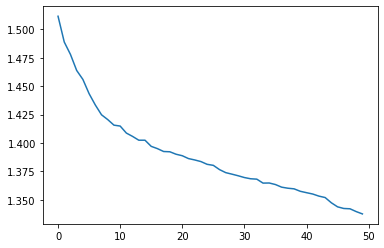

Epoch 1/50
8/8 - 3s - loss: 1.4671 - accuracy: 0.6393 - auc_6: 0.7384 - precision_6: 0.6615 - recall_6: 0.1762 - f1_score: 0.1950 - val_loss: 1.1094 - val_accuracy: 0.6557 - val_auc_6: 0.7854 - val_precision_6: 0.6786 - val_recall_6: 0.1557 - val_f1_score: 0.1980 - 3s/epoch - 330ms/step
Epoch 2/50
8/8 - 1s - loss: 1.4445 - accuracy: 0.6393 - auc_6: 0.7428 - precision_6: 0.7292 - recall_6: 0.1434 - f1_score: 0.1950 - val_loss: 1.1123 - val_accuracy: 0.6557 - val_auc_6: 0.8002 - val_precision_6: 0.7200 - val_recall_6: 0.1475 - val_f1_score: 0.1980 - 678ms/epoch - 85ms/step
Epoch 3/50
8/8 - 1s - loss: 1.4114 - accuracy: 0.6393 - auc_6: 0.7584 - precision_6: 0.7333 - recall_6: 0.1352 - f1_score: 0.1950 - val_loss: 1.1210 - val_accuracy: 0.6557 - val_auc_6: 0.7998 - val_precision_6: 0.6667 - val_recall_6: 0.1148 - val_f1_score: 0.1980 - 645ms/epoch - 81ms/step
Epoch 4/50
8/8 - 1s - loss: 1.3949 - accuracy: 0.6393 - auc_6: 0.7633 - precision_6: 0.7576 - recall_6: 0.1025 - f1_score: 0.1950 - 

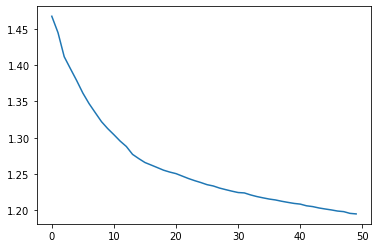

Epoch 1/50
8/8 - 3s - loss: 1.4890 - accuracy: 0.4713 - auc_7: 0.7270 - precision_7: 1.0000 - recall_7: 0.0123 - f1_score: 0.1928 - val_loss: 1.3043 - val_accuracy: 0.4836 - val_auc_7: 0.6716 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_f1_score: 0.1715 - 3s/epoch - 382ms/step
Epoch 2/50
8/8 - 1s - loss: 1.4819 - accuracy: 0.4959 - auc_7: 0.7315 - precision_7: 1.0000 - recall_7: 0.0123 - f1_score: 0.2337 - val_loss: 1.3024 - val_accuracy: 0.5164 - val_auc_7: 0.6694 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_f1_score: 0.2173 - 768ms/epoch - 96ms/step
Epoch 3/50
8/8 - 1s - loss: 1.4685 - accuracy: 0.4877 - auc_7: 0.7387 - precision_7: 1.0000 - recall_7: 0.0123 - f1_score: 0.2327 - val_loss: 1.2987 - val_accuracy: 0.4672 - val_auc_7: 0.6742 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_f1_score: 0.2077 - 669ms/epoch - 84ms/step
Epoch 4/50
8/8 - 1s - loss: 1.4625 - accuracy: 0.4795 - auc_7: 0.7410 - precision_7: 1.0000 - recall_7: 0.01

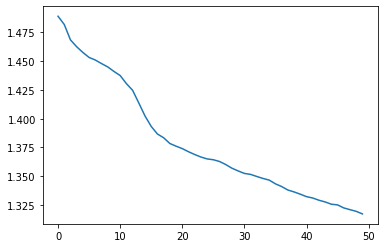

In [14]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    baseline_face_model = Baseline(n_features, n_length, n_outputs)
    history = baseline_face_model.train(X_train, y_train, X_val, y_val, epochs, batch_size, d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [15]:
y_pred = baseline_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = baseline_face_model.evaluate(X_test, y_test)
results.append(round(acc, 2))
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 27.27% 
Balanced Accuracy: 28.54% 
ROC/AUC: 0.58 
Precision: 0.50 
Recall: 0.00 
F1 score: 0.23


## 3. Multimodal Early Fusion

### Dataset

In [16]:
X_train, X_test, y_train, y_test = load_fusioned_dataset(nopain=False)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[2], X_train.shape[3])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2], X_test.shape[3])
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[1], X_train.shape[-1], y_train.shape[1]

(366, 350, 60) (366, 4)
(231, 350, 60) (231, 4)


In [17]:
model = Baseline(n_features, n_length, n_outputs)
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 350, 60)]         0         
                                                                 
 lstm_8 (LSTM)               (None, 50)                22200     
                                                                 
 dense_16 (Dense)            (None, 50)                2550      
                                                                 
 dense_17 (Dense)            (None, 4)                 204       
                                                                 
Total params: 24,954
Trainable params: 24,954
Non-trainable params: 0
_________________________________________________________________


### Baseline Model

Epoch 1/50
8/8 - 3s - loss: 1.6524 - accuracy: 0.1885 - auc_9: 0.4435 - precision_9: 0.2500 - recall_9: 0.0451 - f1_score: 0.0913 - val_loss: 1.5244 - val_accuracy: 0.1967 - val_auc_9: 0.4491 - val_precision_9: 0.1765 - val_recall_9: 0.0246 - val_f1_score: 0.1016 - 3s/epoch - 333ms/step
Epoch 2/50
8/8 - 1s - loss: 1.6142 - accuracy: 0.1844 - auc_9: 0.4554 - precision_9: 0.2857 - recall_9: 0.0492 - f1_score: 0.0895 - val_loss: 1.4966 - val_accuracy: 0.1967 - val_auc_9: 0.4666 - val_precision_9: 0.1429 - val_recall_9: 0.0164 - val_f1_score: 0.1022 - 636ms/epoch - 79ms/step
Epoch 3/50
8/8 - 1s - loss: 1.5903 - accuracy: 0.1926 - auc_9: 0.4677 - precision_9: 0.2895 - recall_9: 0.0451 - f1_score: 0.1028 - val_loss: 1.4641 - val_accuracy: 0.1967 - val_auc_9: 0.4885 - val_precision_9: 0.0769 - val_recall_9: 0.0082 - val_f1_score: 0.1022 - 640ms/epoch - 80ms/step
Epoch 4/50
8/8 - 1s - loss: 1.5660 - accuracy: 0.1926 - auc_9: 0.4853 - precision_9: 0.3125 - recall_9: 0.0410 - f1_score: 0.1026 - 

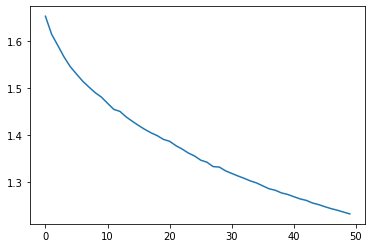

Epoch 1/50
8/8 - 3s - loss: 1.3857 - accuracy: 0.0328 - auc_10: 0.3147 - precision_10: 0.0000e+00 - recall_10: 0.0000e+00 - f1_score: 0.0394 - val_loss: 1.6386 - val_accuracy: 0.0246 - val_auc_10: 0.3169 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00 - val_f1_score: 0.0159 - 3s/epoch - 391ms/step
Epoch 2/50
8/8 - 1s - loss: 1.3628 - accuracy: 0.0410 - auc_10: 0.3341 - precision_10: 0.0000e+00 - recall_10: 0.0000e+00 - f1_score: 0.0455 - val_loss: 1.5973 - val_accuracy: 0.0410 - val_auc_10: 0.3333 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00 - val_f1_score: 0.0271 - 675ms/epoch - 84ms/step
Epoch 3/50
8/8 - 1s - loss: 1.3492 - accuracy: 0.0451 - auc_10: 0.3441 - precision_10: 0.0000e+00 - recall_10: 0.0000e+00 - f1_score: 0.0478 - val_loss: 1.5685 - val_accuracy: 0.0492 - val_auc_10: 0.3368 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00 - val_f1_score: 0.0332 - 700ms/epoch - 88ms/step
Epoch 4/50
8/8 - 1s - loss: 1.3371 - accuracy: 0.0615 - auc_10: 0.

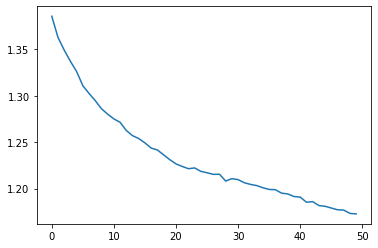

Epoch 1/50
8/8 - 3s - loss: 1.4061 - accuracy: 0.1557 - auc_11: 0.3693 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - f1_score: 0.1291 - val_loss: 1.6587 - val_accuracy: 0.1066 - val_auc_11: 0.3150 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00 - val_f1_score: 0.0912 - 3s/epoch - 330ms/step
Epoch 2/50
8/8 - 1s - loss: 1.3742 - accuracy: 0.1721 - auc_11: 0.4069 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - f1_score: 0.1404 - val_loss: 1.6050 - val_accuracy: 0.1393 - val_auc_11: 0.3461 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00 - val_f1_score: 0.1121 - 673ms/epoch - 84ms/step
Epoch 3/50
8/8 - 1s - loss: 1.3508 - accuracy: 0.2049 - auc_11: 0.4503 - precision_11: 0.0000e+00 - recall_11: 0.0000e+00 - f1_score: 0.1675 - val_loss: 1.5500 - val_accuracy: 0.1721 - val_auc_11: 0.3901 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00 - val_f1_score: 0.1387 - 648ms/epoch - 81ms/step
Epoch 4/50
8/8 - 1s - loss: 1.3346 - accuracy: 0.2254 - auc_11: 0.

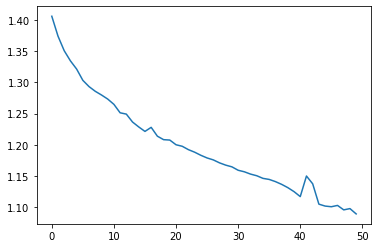

In [18]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = Baseline(n_features, n_length, n_outputs)
    history = model.train(X_train, y_train, X_val, y_val, epochs, batch_size, d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [19]:
y_pred = model.predict(X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(X_test, y_test)
results.append(round(acc, 2))
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 38.53% 
Balanced Accuracy: 29.96% 
ROC/AUC: 0.67 
Precision: 0.00 
Recall: 0.00 
F1 score: 0.24


## 4. Multimodal Late Fusion

### Dataset

In [20]:
body_X_train, body_X_test, body_y_train, body_y_test = load_dataset('skeleton', fusion=True, nopain=False)
body_X_train = body_X_train.reshape(body_X_train.shape[0], body_X_train.shape[2], body_X_train.shape[3])
body_X_test = body_X_test.reshape(body_X_test.shape[0], body_X_test.shape[2], body_X_test.shape[3])
body_X = body_X_train.copy()
body_y = body_y_train.copy()

print(body_X_train.shape, body_y_train.shape)
print(body_X_test.shape, body_y_test.shape)

(366, 350, 35) (366, 4)
(231, 350, 35) (231, 4)


In [21]:
face_X_train, face_X_test, face_y_train, face_y_test = load_dataset('AUs', nopain=False)
face_X_train = face_X_train.reshape(face_X_train.shape[0], face_X_train.shape[2], face_X_train.shape[3])
face_X_test = face_X_test.reshape(face_X_test.shape[0], face_X_test.shape[2], face_X_test.shape[3])
face_X = face_X_train.copy()
face_y = face_y_train.copy()

print(face_X_train.shape, face_y_train.shape)
print(face_X_test.shape, face_y_test.shape)

(366, 350, 25) (366, 4)
(231, 350, 25) (231, 4)


In [22]:
n_length, body_features, face_features, n_outputs = face_X_train.shape[1], body_X_train.shape[-1], face_X_train.shape[-1], body_y_train.shape[1]

### Baseline Model

In [23]:
class fusioned_Baseline():
    def __init__(self, body_features, face_features, n_length, n_outputs):
        input_1 = Input(shape=(n_length, body_features))
        lstm_1 = LSTM(50)(input_1)
        dense_1 = Dense(50)(lstm_1)

        input_2 = Input(shape=(n_length, face_features))
        lstm_2 = LSTM(50)(input_2)
        dense_2 = Dense(50)(lstm_2)

        concat = Concatenate()([dense_1, dense_2])
        output = Dense(units=n_outputs, activation='softmax')(concat)
        model = Model(inputs=[input_1, input_2], outputs=[output])
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit([body_X_train, face_X_train], y_train, validation_data=([body_X_val, face_X_val], y_val), 
                            epochs=epochs, batch_size=batch_size, class_weight=class_weight, verbose=2)
        return history

    def evaluate(self, body_X_test, face_X_test, y_test):
        results = self.model.evaluate([body_X_test, face_X_test], y_test, verbose=0)
        return results

    def predict(self, body_X_test, face_X_test):
        predictions = self.model.predict([body_X_test, face_X_test])
        return predictions

    def summary(self):
        self.model.summary()

In [24]:
model = fusioned_Baseline(body_features, face_features, n_length, n_outputs)
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 350, 35)]    0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 350, 25)]    0           []                               
                                                                                                  
 lstm_12 (LSTM)                 (None, 50)           17200       ['input_13[0][0]']               
                                                                                                  
 lstm_13 (LSTM)                 (None, 50)           15200       ['input_14[0][0]']               
                                                                                           

### Baseline Model

Epoch 1/50
8/8 - 5s - loss: 1.5652 - accuracy: 0.3320 - auc_13: 0.6359 - precision_13: 0.2857 - recall_13: 0.0082 - f1_score: 0.1573 - val_loss: 1.3595 - val_accuracy: 0.2787 - val_auc_13: 0.6014 - val_precision_13: 0.0000e+00 - val_recall_13: 0.0000e+00 - val_f1_score: 0.1259 - 5s/epoch - 574ms/step
Epoch 2/50
8/8 - 1s - loss: 1.4946 - accuracy: 0.3443 - auc_13: 0.6475 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - f1_score: 0.1719 - val_loss: 1.3672 - val_accuracy: 0.2787 - val_auc_13: 0.5859 - val_precision_13: 0.0000e+00 - val_recall_13: 0.0000e+00 - val_f1_score: 0.1342 - 803ms/epoch - 100ms/step
Epoch 3/50
8/8 - 1s - loss: 1.4395 - accuracy: 0.3320 - auc_13: 0.6498 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - f1_score: 0.1810 - val_loss: 1.3663 - val_accuracy: 0.2541 - val_auc_13: 0.5842 - val_precision_13: 0.0000e+00 - val_recall_13: 0.0000e+00 - val_f1_score: 0.1439 - 834ms/epoch - 104ms/step
Epoch 4/50
8/8 - 1s - loss: 1.3866 - accuracy: 0.3443 - auc_13: 0.6632 -

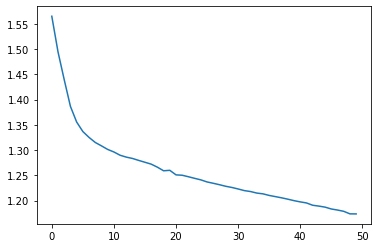

Epoch 1/50
8/8 - 4s - loss: 1.3930 - accuracy: 0.1516 - auc_14: 0.4361 - precision_14: 0.0769 - recall_14: 0.0082 - f1_score: 0.0908 - val_loss: 1.4613 - val_accuracy: 0.1557 - val_auc_14: 0.5280 - val_precision_14: 0.3636 - val_recall_14: 0.0328 - val_f1_score: 0.0802 - 4s/epoch - 506ms/step
Epoch 2/50
8/8 - 1s - loss: 1.3279 - accuracy: 0.1598 - auc_14: 0.5017 - precision_14: 0.0000e+00 - recall_14: 0.0000e+00 - f1_score: 0.0959 - val_loss: 1.4302 - val_accuracy: 0.1557 - val_auc_14: 0.5421 - val_precision_14: 0.6000 - val_recall_14: 0.0246 - val_f1_score: 0.0821 - 856ms/epoch - 107ms/step
Epoch 3/50
8/8 - 1s - loss: 1.2818 - accuracy: 0.1680 - auc_14: 0.5423 - precision_14: 0.0000e+00 - recall_14: 0.0000e+00 - f1_score: 0.1023 - val_loss: 1.3987 - val_accuracy: 0.1803 - val_auc_14: 0.5616 - val_precision_14: 0.5000 - val_recall_14: 0.0082 - val_f1_score: 0.1034 - 799ms/epoch - 100ms/step
Epoch 4/50
8/8 - 1s - loss: 1.2493 - accuracy: 0.2049 - auc_14: 0.5775 - precision_14: 0.0000e+0

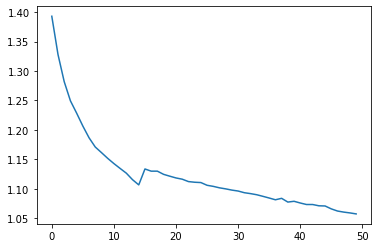

Epoch 1/50
8/8 - 4s - loss: 1.4924 - accuracy: 0.3361 - auc_15: 0.6987 - precision_15: 0.0000e+00 - recall_15: 0.0000e+00 - f1_score: 0.1868 - val_loss: 1.2942 - val_accuracy: 0.3443 - val_auc_15: 0.6922 - val_precision_15: 0.0000e+00 - val_recall_15: 0.0000e+00 - val_f1_score: 0.1802 - 4s/epoch - 555ms/step
Epoch 2/50
8/8 - 1s - loss: 1.4712 - accuracy: 0.3443 - auc_15: 0.7182 - precision_15: 0.0000e+00 - recall_15: 0.0000e+00 - f1_score: 0.2141 - val_loss: 1.2958 - val_accuracy: 0.3197 - val_auc_15: 0.6938 - val_precision_15: 0.0000e+00 - val_recall_15: 0.0000e+00 - val_f1_score: 0.1583 - 821ms/epoch - 103ms/step
Epoch 3/50
8/8 - 1s - loss: 1.4439 - accuracy: 0.3730 - auc_15: 0.7353 - precision_15: 0.0000e+00 - recall_15: 0.0000e+00 - f1_score: 0.2347 - val_loss: 1.3008 - val_accuracy: 0.3361 - val_auc_15: 0.6860 - val_precision_15: 0.0000e+00 - val_recall_15: 0.0000e+00 - val_f1_score: 0.1848 - 823ms/epoch - 103ms/step
Epoch 4/50
8/8 - 1s - loss: 1.4321 - accuracy: 0.3893 - auc_15: 

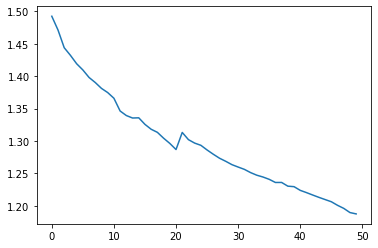

In [25]:
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    body_y_train, body_y_val = body_y[train_index], body_y[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    face_y_train, face_y_val = face_y[train_index], face_y[val_index]
    model = fusioned_Baseline(body_features, face_features, n_length, n_outputs)
    history = model.train(body_X_train, face_X_train, body_y_train, body_X_val, face_X_val, face_y_val, epochs, batch_size, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [26]:
y_pred = model.predict(body_X_test, face_X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(body_X_test, face_X_test, body_y_test)
results.append(round(auc, 2))
bal_acc = balanced_accuracy_score(body_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 32.03% 
Balanced Accuracy: 25.97% 
ROC/AUC: 0.65 
Precision: 0.60 
Recall: 0.03 
F1 score: 0.24


### Ensemble

In [27]:
baseline_body_member = KerasMember(name="Body Model", keras_model=baseline_body_model, train_batches=(body_X_train, y_train), val_batches=(body_X_test, body_y_test))
baseline_face_member = KerasMember(name="Face Model", keras_model=baseline_face_model, train_batches=(face_X_train, face_y_train), val_batches=(face_X_test, face_y_test))

In [28]:
dirichletEnsemble = DirichletEnsemble()
dirichletEnsemble.add_member(baseline_body_member)
dirichletEnsemble.add_member(baseline_face_member)
dirichletEnsemble.fit()

In [29]:
e = dirichletEnsemble.describe()
results.append(round(e, 2))

Body Model (weight: 0.9522)
Face Model (weight: 0.0478)
Accuracy: 37.66% - ROC/AUC: 0.50 - Precision: 0.26 - Recall: 0.29 - F1 score: 0.24


## Results

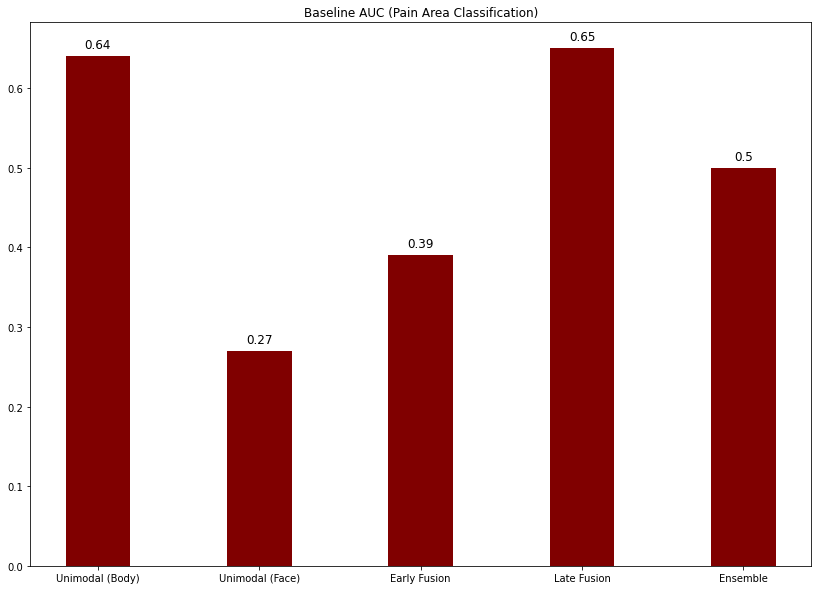

In [30]:
data = {'Unimodal (Body)':results[0], 'Unimodal (Face)':results[1], 'Early Fusion':results[2],
        'Late Fusion':results[3], 'Ensemble':results[4]}
models = list(data.keys())
performance = list(data.values())
  
fig = plt.figure(figsize = (14, 10))
 
plt.bar(models, performance, color ='maroon',
        width = 0.4)

plt.text(0, performance[0] + 0.01, performance[0], ha='center', fontsize=12)
plt.text(1, performance[1] + 0.01, performance[1], ha='center', fontsize=12)
plt.text(2, performance[2] + 0.01, performance[2], ha='center', fontsize=12)
plt.text(3, performance[3] + 0.01, performance[3], ha='center', fontsize=12)
plt.text(4, performance[4] + 0.01, performance[4], ha='center', fontsize=12)
 
plt.title("Baseline AUC (Pain Area Classification)")
plt.show()